In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### GAN Implementation Project 

It is mainly used in Deep Flakes Problems

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
mnist = tf.keras.datasets.mnist

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()  ##Loaded Mnist datasets

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


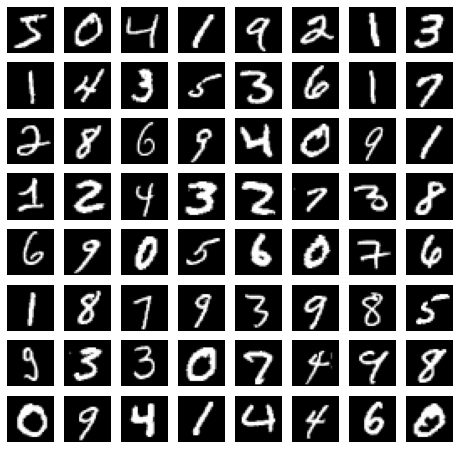

In [5]:
plt.figure(figsize = (8, 8))  ##Plotting the handwritten images
for i in range(64):
  plt.subplot(8, 8, 1+i)
  plt.axis('off')
  plt.imshow(X_train[i], cmap = 'gray')

In [6]:
##Normalise

X_train = X_train / 255

In [7]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1) 

In [8]:
##defining random noise that will feed to generator

codings_size = 30 #a set of random values at which it will generate fake images



generator = keras.models.Sequential([
                      keras.layers.Dense(100, activation = 'selu', input_shape = [codings_size]),
                      keras.layers.Dense(150, activation = 'selu'),
                      keras.layers.Dense(28*28, activation = 'sigmoid'),
                      keras.layers.Reshape([28,28])
])

In [9]:
## Building discrimanator Neural Network....Simple RNN

discriminator = keras.models.Sequential([
                                        keras.layers.Flatten(input_shape = [28, 28]),
                                        keras.layers.Dense(150, activation = 'selu'),
                                        keras.layers.Dense(100, activation = 'selu'),
                                        keras.layers.Dense(1, activation = 'sigmoid')
])

In [10]:
gan = keras.models.Sequential([generator, discriminator])  ##Completed architecture of GAN

In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               3100      
_________________________________________________________________
dense_1 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               118384    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 136,634
Trainable params: 136,634
Non-trainable params: 0
_________________________________________________________________


In [12]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 150)               117750    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 132,951
Trainable params: 132,951
Non-trainable params: 0
_________________________________________________________________


In [13]:
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28)            136634    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 132951    
Total params: 269,585
Trainable params: 269,585
Non-trainable params: 0
_________________________________________________________________


In [14]:
#We are going to take equal number of real images as fake images
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')
discriminator.trainable = False #It means discriminator parameters are not going to be updated. Generator parameters are going to be updated.
gan.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop') #In GAN, discriminator parameters are non trainable.

In [15]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs = 10):
  generator, discriminator = gan.layers  #Two layers are going to return. One will save in Generator 28*28 and second will be store in Discriminator, output will be 1 whether image is real or fake.
  for epoch in range(n_epochs): #outer loop is for number of epochs
    for X_batch in dataset: #inner loop is for batches 32 images it creates
      # training the discriminator
      noise = tf.random.normal(shape = [batch_size, codings_size])#we are providing random seed of 30.So, matrix of batch_size *codings_size. We want to generate 32 fake images. It will combine equal number of real images to feed into discriminator.
      generated_images = generator(noise)
      X_batch = tf.cast(X_batch, tf.float32)#We are typecasting it in float to match with generated_images.
      X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0) #It will combine 32 fake images and 32 real images
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) #labelling images as 0 for 32 fake images and 1 for 32 real images.
      discriminator.trainable = True #to avoid warning setting discriminator trainable as True again.
      discriminator.train_on_batch(X_fake_and_real, y1) #training the discriminator.

      #training the generator
      noise = tf.random.normal(shape = [batch_size, codings_size])
      y2 = tf.constant(([[1.]] * batch_size))  #we want GAN to generate fake images that should be closer to real images, that's why labelled as 1.
      discriminator.trainable = False
      gan.train_on_batch(noise, y2)

  plt.figure(figsize=(6,6))
  for i in range(32):
    plt.subplot(8, 4, 1+i)
    plt.axis('off')
    plt.imshow(generated_images[i], cmap = 'gray')




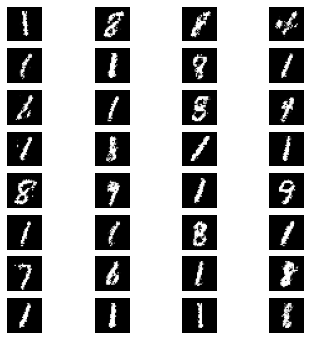

In [16]:
train_gan(gan, dataset, batch_size, codings_size)

In [17]:
noise = tf.random.normal(shape = [1,codings_size])
generated_image = generator(noise)
generated_image.shape

TensorShape([1, 28, 28])

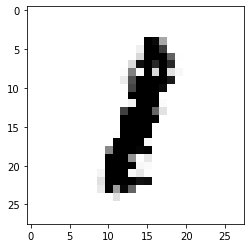

In [21]:
plt.figure()
plt.imshow(generated_image[0], cmap = 'gray_r')

## Neural Style Transfer

We take 2 images. One content image and one style image. It feed to Neural Networks. It change the content image as per the style images.

###Tensorflow Hub: It is a repository that provides pre-trained model. It is used in Transfer Learning.

In [47]:
import tensorflow_hub as hub
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [50]:
model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2') #copied URL from Tensorflow Hub for style-transfering.

In [51]:
def load_image(img_path):
    img = tf.io.read_file(img_path) #reading the file path.
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :] #It is reshaping
    return img

In [53]:
content_image =  load_image('/content/images/panda.jpeg')
style_image = load_image('/content/images/monet.jpeg')

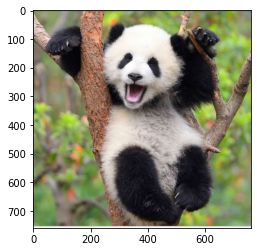

In [54]:
plt.imshow(np.squeeze(content_image)) #squeeze function---> eliminates single dimension.

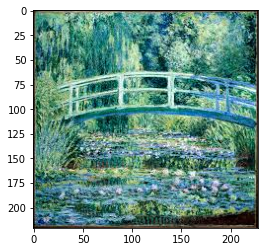

In [55]:
plt.imshow(np.squeeze(style_image))

In [58]:
stylized_image = model(tf.constant(content_image), tf.constant(style_image))[0] #image is stored in the first index that's why we are using 0. It stores a lot of information. SO, we are using 1st index value only.

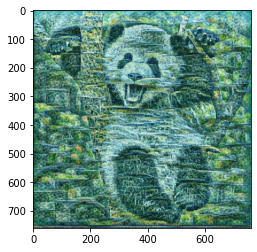

In [59]:
plt.imshow(np.squeeze(stylized_image))

In [60]:
content_image =  load_image('/content/images/baby_yoda.jpeg')
style_image = load_image('/content/images/starrynight.jpeg')

In [61]:
stylized_image = model(tf.constant(content_image), tf.constant(style_image))[0] #image is stored in the first index that's why we are using 0. It stores a lot of information. SO, we are using 1st index value only.

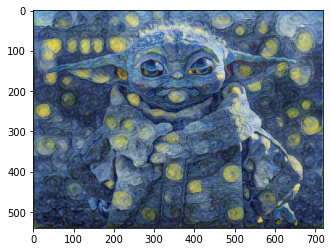

In [62]:
plt.imshow(np.squeeze(stylized_image))

### Transfer Learning

## Data Augmentation


In [63]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-05-16 14:52:15--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 173.194.203.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   106MB/s    in 0.6s    

2021-05-16 14:52:15 (106 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [64]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [65]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')